# estimator classifier

## imports

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

## data

In [3]:
diabetes = pd.read_csv(
    "../../FULL-TENSORFLOW-NOTES-AND-DATA/Tensorflow-Bootcamp-master/02-TensorFlow-Basics/pima-indians-diabetes.csv"
)
diabetes.head(3)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.0,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.0,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.0,0.347243,0.253629,32,1,B


### cleaning
Here we'll preprocess the data.
#### normalization
Continuous numeric columns will be normalized below.

In [5]:
list(diabetes.columns)

['Number_pregnant',
 'Glucose_concentration',
 'Blood_pressure',
 'Triceps',
 'Insulin',
 'BMI',
 'Pedigree',
 'Age',
 'Class',
 'Group']

In [13]:
cols_to_norm = list(diabetes.columns)[:-3]
cols_to_norm

['Number_pregnant',
 'Glucose_concentration',
 'Blood_pressure',
 'Triceps',
 'Insulin',
 'BMI',
 'Pedigree']

In [7]:
diabetes[cols_to_norm] = diabetes[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
diabetes.head(3)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,0.352941,0.743719,0.590164,0.353535,0.0,0.500745,0.234415,50,1,B
1,0.058824,0.427136,0.540984,0.292929,0.0,0.396423,0.116567,31,0,C
2,0.470588,0.919598,0.524590,0.000000,0.0,0.347243,0.253629,32,1,B


## feature columns
### numeric

In [20]:
feat_cols_num = cols_to_norm[:]
feat_cols_num.append("Age")
feat_cols_num

['Number_pregnant',
 'Glucose_concentration',
 'Blood_pressure',
 'Triceps',
 'Insulin',
 'BMI',
 'Pedigree',
 'Age']

In [21]:
feat_cols_map = {}
for i in range(len(feat_cols_num)):
    key = feat_cols_num[i]
    feat_cols_map[key] = tf.feature_column.numeric_column(key)
feat_cols_map

{'Age': _NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'BMI': _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Blood_pressure': _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Glucose_concentration': _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Insulin': _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Number_pregnant': _NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Pedigree': _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Triceps': _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)}

### categorical

In [29]:
sorted(diabetes["Group"].unique().tolist())

['A', 'B', 'C', 'D']

In [30]:
#vocab list implementation
assigned_group = tf.feature_column.categorical_column_with_vocabulary_list(
    "Group",
    sorted(diabetes["Group"].unique().tolist())
)

In [32]:
#hash bucket implementation
"""
assigned_group = tf.feature_column.categorical_column_with_hash_bucket(
    "Group",
    len(diabetes["Group"].unique().tolist())
)"""

'\nassigned_group = tf.feature_column.categorical_column_with_hash_bucket(\n    "Group",\n    len(diabetes["Group"].unique().tolist())\n)'

#### age
We'll convert age to a categorical column.

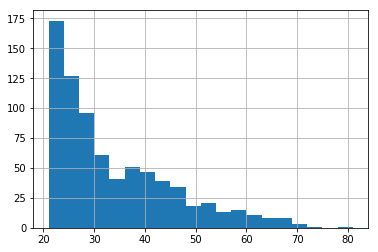

In [33]:
diabetes["Age"].hist(bins=20)

We'll break age up into buckets.

In [35]:
feat_cols_map["Age"] = tf.feature_column.bucketized_column(
    feat_cols_map["Age"],
    boundaries=[i for i in range(20, 90, 10)]
)

## something here

In [38]:
feat_cols = [feat_cols_map[k] for k in feat_cols_map]
feat_cols.append(assigned_group)
feat_cols

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _BucketizedColumn(source_column=_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(20, 30, 40, 50, 60, 70, 80)),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _HashedCategoricalColumn(key='Group', hash_bucket_size=4, dtype=tf.string)]

## splitting the data

In [41]:
x = diabetes.drop("Class", axis=1)
x.head(3)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Group
0,0.352941,0.743719,0.590164,0.353535,0.0,0.500745,0.234415,50,B
1,0.058824,0.427136,0.540984,0.292929,0.0,0.396423,0.116567,31,C
2,0.470588,0.919598,0.524590,0.000000,0.0,0.347243,0.253629,32,B


In [43]:
y = diabetes[["Class"]]
y.head(3)

,Class
0,1
1,0
2,1


In [44]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.3,
    random_state=101
)

## input functions

In [45]:
batch_size = 10
num_epochs = 1000

In [46]:
input_func = tf.estimator.inputs.pandas_input_fn(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    num_epochs=num_epochs,
    shuffle=True
)

In [47]:
model = tf.estimator.LinearClassifier(feature_columns=feat_cols, n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1, '_session_config': None, '_model_dir': 'C:\\Users\\unknown\\AppData\\Local\\Temp\\tmp08lwzm4c', '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100}


## training

In [48]:
model.train(input_func, steps=num_epochs)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\unknown\AppData\Local\Temp\tmp08lwzm4c\model.ckpt.
INFO:tensorflow:loss = 6.93147, step = 1
INFO:tensorflow:global_step/sec: 676.682
INFO:tensorflow:loss = 5.94296, step = 101 (0.148 sec)
INFO:tensorflow:global_step/sec: 776.41
INFO:tensorflow:loss = 6.79273, step = 201 (0.129 sec)
INFO:tensorflow:global_step/sec: 877.29
INFO:tensorflow:loss = 5.17376, step = 301 (0.114 sec)
INFO:tensorflow:global_step/sec: 753.891
INFO:tensorflow:loss = 4.89421, step = 401 (0.133 sec)
INFO:tensorflow:global_step/sec: 815.18
INFO:tensorflow:loss = 5.29588, step = 501 (0.124 sec)
INFO:tensorflow:global_step/sec: 886.807
INFO:tensorflow:loss = 5.87631, step = 601 (0.114 sec)
INFO:tensorflow:global_step/sec: 831.158
INFO:tensorflow:loss = 4.96011, step = 701 (0.119 sec)
INFO:tensorflow:global_step/sec: 884.404
INFO:tensorflow:loss = 4.85345, step = 801 (0.113 sec)
INFO:tensorflow:global_step/sec: 877.231
INF

## evaluation

In [49]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
    x=x_test,
    y=y_test,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False
)

In [50]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Starting evaluation at 2018-06-05-02:17:39
INFO:tensorflow:Restoring parameters from C:\Users\unknown\AppData\Local\Temp\tmp08lwzm4c\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-06-05-02:17:40
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.735931, accuracy_baseline = 0.649351, auc = 0.800247, auc_precision_recall = 0.649007, average_loss = 0.527118, global_step = 1000, label/mean = 0.350649, loss = 5.07351, prediction/mean = 0.378


{'accuracy': 0.73593074,
 'accuracy_baseline': 0.64935064,
 'auc': 0.80024689,
 'auc_precision_recall': 0.64900744,
 'average_loss': 0.52711803,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 5.0735111,
 'prediction/mean': 0.37800026}

### predictions

In [51]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(
    x=x_test,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False
)

In [52]:
predictions = list(model.predict(pred_input_func))
predictions

INFO:tensorflow:Restoring parameters from C:\Users\unknown\AppData\Local\Temp\tmp08lwzm4c\model.ckpt-1000


[{'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.52600718], dtype=float32),
  'logits': array([ 0.10412276], dtype=float32),
  'probabilities': array([ 0.47399279,  0.52600718], dtype=float32)},
 {'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.64833593], dtype=float32),
  'logits': array([ 0.6117326], dtype=float32),
  'probabilities': array([ 0.35166407,  0.64833593], dtype=float32)},
 {'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.37726167], dtype=float32),
  'logits': array([-0.50118744], dtype=float32),
  'probabilities': array([ 0.62273836,  0.37726167], dtype=float32)},
 {'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.34498891], dtype=float32),
  'logits': array([-0.64113986], dtype=float32),
  'probabilities': array([ 0.65501112,  0.34498894], dtype=floa

# dense neural network classifier

In [54]:
#neural network with 3 layers of 10 neurons each
dnn_model = tf.estimator.DNNClassifier(
    hidden_units=[10]*3,
    feature_columns=feat_cols,
    n_classes=2
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1, '_session_config': None, '_model_dir': 'C:\\Users\\unknown\\AppData\\Local\\Temp\\tmpm9sp0goy', '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100}


Training a DNN with categorical columns in this fashion will give you an error.

In [55]:
dnn_model.train(input_fn=input_func, steps=num_epochs)

ValueError: Items of feature_columns must be a _DenseColumn. You can wrap a categorical column with an embedding_column or indicator_column. Given: _HashedCategoricalColumn(key='Group', hash_bucket_size=4, dtype=tf.string)

In order to deal with categorical columns, we'll proceed as follows (see error message above).

In [60]:
#embedding column
embedded_group_col = tf.feature_column.embedding_column(
    categorical_column=assigned_group,
    dimension=len(diabetes["Group"].unique())
)

In [61]:
feat_cols

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _BucketizedColumn(source_column=_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(20, 30, 40, 50, 60, 70, 80)),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _HashedCategoricalColumn(key='Group', hash_bucket_size=4, dtype=tf.string)]

Remove the old categorical column and replace it with the embedded column.

In [63]:
feat_cols_dnn = feat_cols[:-1]
feat_cols_dnn.append(embedded_group_col)
feat_cols_dnn

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _BucketizedColumn(source_column=_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(20, 30, 40, 50, 60, 70, 80)),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _EmbeddingColumn(categorical_column=_HashedCategoricalColumn(key='Group', hash_bucket_s

In [64]:
input_func_dnn = tf.estimator.inputs.pandas_input_fn(
    x_train, y_train, batch_size=batch_size, num_epochs=num_epochs, shuffle=True
)

In [65]:
dnn_model = tf.estimator.DNNClassifier(
    hidden_units=[10]*3, feature_columns=feat_cols_dnn, n_classes=2
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1, '_session_config': None, '_model_dir': 'C:\\Users\\unknown\\AppData\\Local\\Temp\\tmp0fc6lapz', '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100}


## training

In [66]:
dnn_model.train(input_fn=input_func_dnn, steps=num_epochs)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\unknown\AppData\Local\Temp\tmp0fc6lapz\model.ckpt.
INFO:tensorflow:loss = 7.13314, step = 1
INFO:tensorflow:global_step/sec: 757.364
INFO:tensorflow:loss = 6.67179, step = 101 (0.134 sec)
INFO:tensorflow:global_step/sec: 861.696
INFO:tensorflow:loss = 5.08284, step = 201 (0.117 sec)
INFO:tensorflow:global_step/sec: 879.541
INFO:tensorflow:loss = 4.66329, step = 301 (0.114 sec)
INFO:tensorflow:global_step/sec: 821.284
INFO:tensorflow:loss = 7.92157, step = 401 (0.121 sec)
INFO:tensorflow:global_step/sec: 783.339
INFO:tensorflow:loss = 7.36643, step = 501 (0.128 sec)
INFO:tensorflow:global_step/sec: 903.314
INFO:tensorflow:loss = 5.68711, step = 601 (0.112 sec)
INFO:tensorflow:global_step/sec: 842.582
INFO:tensorflow:loss = 3.40953, step = 701 (0.118 sec)
INFO:tensorflow:global_step/sec: 895.247
INFO:tensorflow:loss = 2.78877, step = 801 (0.113 sec)
INFO:tensorflow:global_step/sec: 887.319


## evaluation

In [67]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
    x=x_test, y=y_test, batch_size=batch_size, num_epochs=1, shuffle=False
)

In [68]:
dnn_model.evaluate(input_fn=eval_input_func)

INFO:tensorflow:Starting evaluation at 2018-06-05-02:35:57
INFO:tensorflow:Restoring parameters from C:\Users\unknown\AppData\Local\Temp\tmp0fc6lapz\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-06-05-02:35:57
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.753247, accuracy_baseline = 0.649351, auc = 0.84, auc_precision_recall = 0.724874, average_loss = 0.470352, global_step = 1000, label/mean = 0.350649, loss = 4.52714, prediction/mean = 0.377156


{'accuracy': 0.75324672,
 'accuracy_baseline': 0.64935064,
 'auc': 0.84000003,
 'auc_precision_recall': 0.72487354,
 'average_loss': 0.4703522,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 4.5271401,
 'prediction/mean': 0.37715587}